In [42]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adadelta
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Paths

In [43]:
#File paths
main_path_energy ='../data_base/paths_energy/'
main_path_total_energy = '../data_base/paths_totals/'

energy_path11_pd = pd.read_csv(main_path_energy + 'feat_pathv11.csv')
energy_path12_pd = pd.read_csv(main_path_energy + 'feat_pathv12-2.csv')
energy_path13_pd = pd.read_csv(main_path_energy + 'feat_pathv13.csv')

energy_path_list = [energy_path11_pd,energy_path12_pd,energy_path13_pd]
complete_energy_pd = pd.concat(energy_path_list)

total_path11_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv11.csv')
total_path12_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv12-2.csv')
total_path13_pd = pd.read_csv(main_path_total_energy + 'totalF_pathv13.csv')

total_path_list = [total_path11_pd,total_path12_pd,total_path13_pd]
complete_total_pd = pd.concat(total_path_list)

### Data split and preprocessing - complete_energy_pd - All data

this data comes from the folder "paths_energy"

In [44]:
X = complete_energy_pd.drop(columns=["missing_points","path_num","sim_drone_time","Energy","sim_point_dist","sim_Xdist","sim_Ydist","avg_error_target_dist","avg_energy"],axis=1)
y = complete_energy_pd["Energy"].to_numpy()

X = X.to_numpy()

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=35)

scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(f'Train size/Test size {len(x_train),len(x_test)}')

Train size/Test size (2486, 622)


### Model - Neural network - relu and linear

In [45]:
NN_model = Sequential()

ran_initial = RandomNormal(seed=35)

NN_model.add(Dense(64,kernel_initializer=ran_initial,input_dim=7,activation='relu'))

NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))

NN_model.add(Dense(1, kernel_initializer=ran_initial,activation='linear'))

NN_model.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.1), metrics=["mean_squared_logarithmic_error"])
NN_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_49 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_51 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_52 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 129       
Total params: 58,497
Trainable params: 58,497
Non-trainable params: 0
__________________________________________________

In [46]:
model1 = NN_model.fit(x_train, y_train, epochs=300, batch_size=32, validation_split = 0.2,verbose=0)

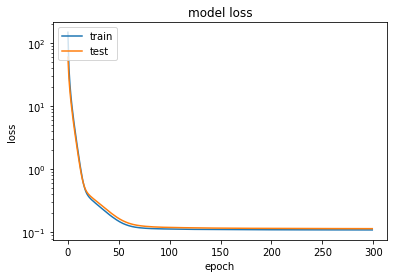

In [47]:
plt.plot(model1.history['loss'])
plt.plot(model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
y_predict = NN_model.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

r2: 0.643760734129587
RMSE: 1141891.9040126537
MSE: 1303917120449.6436


### Data split and preprocessing - complete_energy_pd - with eps

In [49]:
eps = 5
complete_energy_pd = complete_energy_pd[(complete_energy_pd['sim_point_dist']-complete_energy_pd['teo_point_dist']) < eps]
print(f'new shape of complete_energy_pd = {complete_energy_pd.shape}')

new shape of complete_energy_pd = (2577, 16)


In [50]:
X = complete_energy_pd.drop(columns=["missing_points","path_num","sim_drone_time","Energy","sim_point_dist","sim_Xdist","sim_Ydist","avg_error_target_dist","avg_energy"],axis=1)
y = complete_energy_pd["Energy"].to_numpy()

X = X.to_numpy()

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=35)

scaler2 = StandardScaler()

x_train = scaler2.fit_transform(x_train)
x_test = scaler2.transform(x_test)

print(f'Train size/Test size {len(x_train),len(x_test)}')

Train size/Test size (2061, 516)


In [51]:
NN_model11 = Sequential()

ran_initial = RandomNormal(seed=35)

NN_model11.add(Dense(64,kernel_initializer=ran_initial,input_dim=7,activation='relu'))

NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))
NN_model11.add(Dense(128,kernel_initializer=ran_initial,activation='relu'))

NN_model11.add(Dense(1, kernel_initializer=ran_initial,activation='linear'))

NN_model11.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.2), metrics=["mean_squared_logarithmic_error"])

In [52]:
model11 = NN_model11.fit(x_train, y_train, epochs=100, batch_size=32, validation_split = 0.2,verbose=0)

In [53]:
y_predict = NN_model11.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

r2: 0.7332549228365288
RMSE: 739417.7325779363
MSE: 546738583250.6965


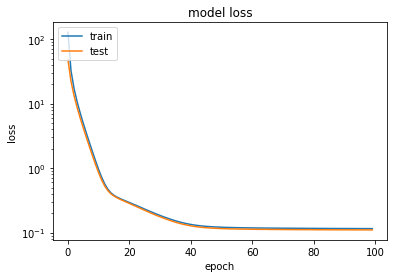

In [54]:
plt.plot(model11.history['loss'])
plt.plot(model11.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model - Neural network - sigmoid and linear

In [55]:
NN_model2 = Sequential()

NN_model2.add(Dense(128,kernel_initializer='normal',input_dim=7,activation='sigmoid'))

NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))
NN_model2.add(Dense(128,kernel_initializer='normal',activation='sigmoid'))

NN_model2.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model2.compile(loss="mean_squared_logarithmic_error", optimizer=Adadelta(learning_rate=0.1), metrics=["mean_squared_logarithmic_error"])
NN_model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 128)               1024      
_________________________________________________________________
dense_61 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_62 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_63 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_64 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 129       
Total params: 67,201
Trainable params: 67,201
Non-trainable params: 0
_________________________________________________

In [56]:
model2 = NN_model2.fit(x_train, y_train, epochs=350, batch_size=32, validation_split = 0.2,verbose=0)

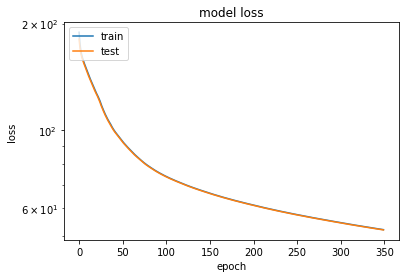

In [57]:
plt.plot(model2.history['loss'])
plt.plot(model2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [58]:
y_predict = NN_model2.predict(x_test)
r2 = r2_score(y_test,y_predict)
RMSE = mean_squared_error(y_test,y_predict,squared=False)
MSE = mean_squared_error(y_test,y_predict)

print(f'r2: {r2}')
print(f'RMSE: {RMSE}')
print(f'MSE: {MSE}')

r2: -1.6537800749166798
RMSE: 2332244.72483415
MSE: 5439365456516.722
